## Decision tree

Decision tree is a statistical method used to build a classification model. With this model, one can describe how the values of the target variable is obtained using feature variables. Generally we want more than description of a dataset at hand from our model, we also want it to be able to predict future, "yet unseen" value of the target variable based on values of the feature variables. 

In the following, the 'Heart Failure Prediction Dataset' is used from kaggle.com : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

The aim is to describe and predict occurrence of heart failure (=target variable) based on different attributes of the person (=features). 

**The following is included in this project**:

In [Data preparation](#section1) we will check the dataset for missing values, check the distributions of the variables, and transform variables.

In [Data evaluation I.](#section2) we will investigate the performance of a decision tree model **without** hyperparameters tuning. The performance indicator is the predictive accuracy of **repeated hold-out test sets**.

In [Data evaluation II.](#section3) we will investigate the performance of a decision tree model **with** hyperparameters tuning. Both the hyperparameters and the test validation is based on the the descriptive accuracy of the train sets and the predictive accuracy of **repeated hold-out test sets**. With this method we introduce bias in the model selection by selecting the model that best suits the test set (it is actually a fake hold-out test set), and by handpicking the "best" model. 

In [Data evaluation III.](#section4) we will investigate the performance of a decision tree model **with** hyperparameters tuning. We will use a simple **k-fold cross-validation** method. While this method is appropriate for tuning the hyperparameters, its performance indicator is overoptimistic. 

In [Data evaluation IV.](#section5) we will investigate the performance of a decision tree model **with** hyperparameters tuning. We will use **repeated k-fold cross-validation** to tune. The repeatation descreses the uncertainity in the performance test indicator, allow us to better distinguish the hyperparameter sets and select the "best" more efficiently. 

In [Data evaluation V.](#section6) we will investigate the performance of a decision tree model **with** hyperparameters tuning. We will use a **repeated nested cross-validation** design to see the general performance of the model building on our dataset, and use the "best" hyperparameter settings as candidate settings in a (repeated) cross-validation to tune the final model. This approach is almost the same as the one in [Data evaluation II.](#Data-evaluation-II.-:-Tuning-hyperparameters-using-the-repeated-hold-out-test-set-method). The difference is that here, the inner loop uses cross-validation, thus we do not introduce bias in the model selection process.




<a id='section1'></a>

### <ins>Data preparation<ins> 
Let's import the required modules to define our feature set and target set using a copy of the original kaggle .csv file from my github repository:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(
    "https://raw.githubusercontent.com/MMateo1120/machine_learning_tutorials/main/heart.csv"
)

features = data.columns[:-1]
target = data.columns[-1]

X = data[features]
y = data[target].to_frame()

display(X)
display(y)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


,HeartDisease
0,0
1,1
2,0
3,1
4,0
...,...
913,1
914,1
915,1
916,1


#### *Data cleaning*
Let's check the features, from various perspectives. First check if missing values are in the dataset:

In [2]:
X.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
dtype: int64

There is no missing value in the dataset. Let's plot the values of the features:

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>],
       [<Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'FastingBS'}>],
       [<Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>]], dtype=object)

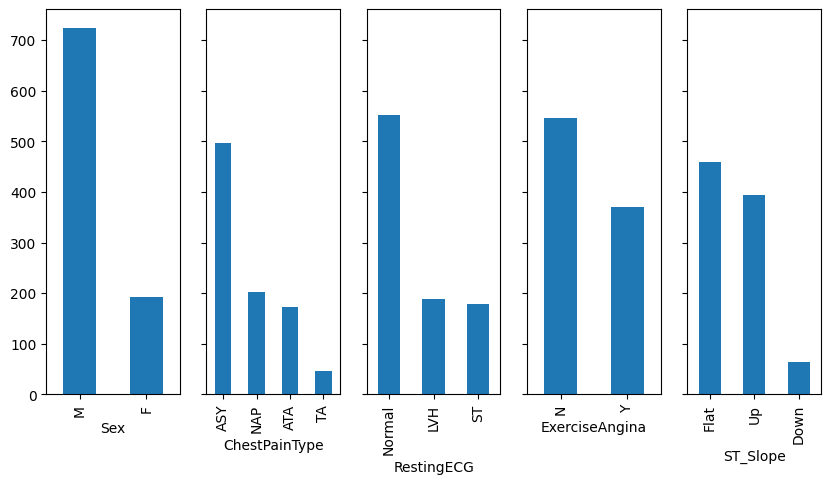

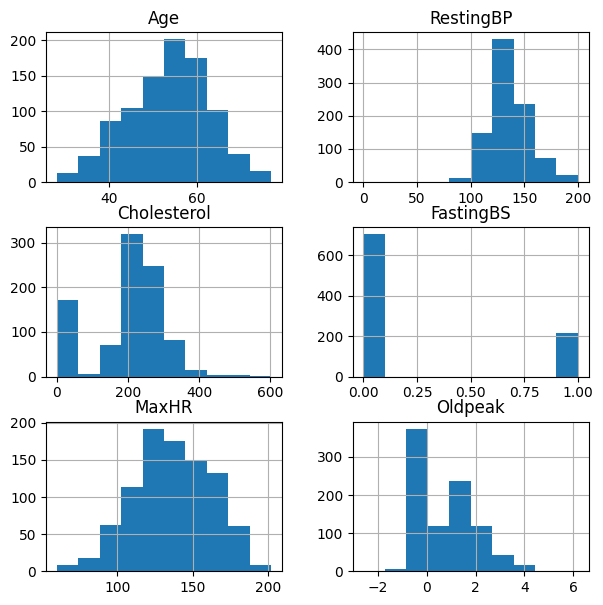

In [3]:
# finding features that are categorical based on the coding of their values:
categorical = []
for column in X.columns:
    if isinstance(X[column][0], str):
        categorical.append(column)

# plot categorical features in a shared figure
nrow = 1
ncol = X[categorical].shape[1]
fig, axes = plt.subplots(nrow, ncol, sharey=True, figsize=(10, 5))

for c in range(ncol):
    X[categorical[c]].value_counts().plot(kind="bar", ax=axes[c])

# plot features with seemingly continous values
X.hist(figsize=(7, 7))

Although the feautre 'Oldpeak' appears in the lower figure along with the continous features, it is categorical feature which is (already) coded with 0 and 1.
<br/>

Values of cholesterols seems to come from two different distributions: one that centered around 200, and one around 0. Let's plot the cholesterol data in id order:

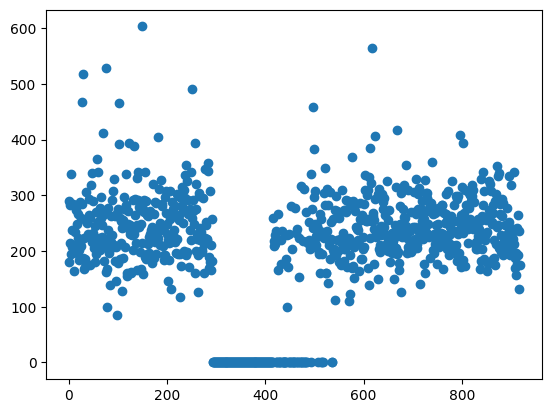

In [4]:
plt.scatter(X.index, X["Cholesterol"])

It seems the values between around id of 300 and 400 are all zeros, and up to 550 zeros appears in the dataset. The dataset is based on data from four sources as it is read at https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction, and it is possible that for some patients (maybe that belongs to one of the sources) cholesterol was not measured and used values of zero to fill the missing cells. Nonetheless, as no further information is available on these data, we will ommit these data from our dataset:

In [5]:
y = y.loc[X["Cholesterol"] > 0].reset_index(drop=True)
X = X.loc[X["Cholesterol"] > 0].reindex().reset_index(drop=True)

display(X)
display(y)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...
741,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
742,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
743,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
744,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


,HeartDisease
0,0
1,1
2,0
3,1
4,0
...,...
741,1
742,1
743,1
744,1


##### *Imbalance check*

Let's check the target values for imbalance issues:

<Axes: ylabel='count'>

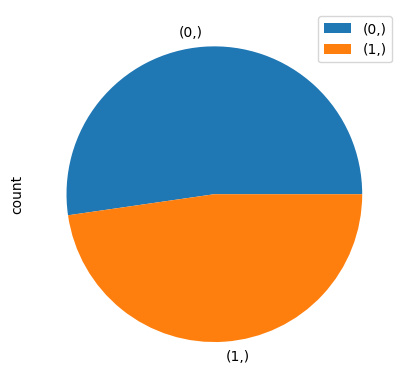

In [6]:
y.value_counts().to_frame().plot(kind='pie', y="count")

In the target variable '0' marks no occurrence heart failure and '1' marks occurrence of heart failure. As the ratio of 1 and 0 are close to 1, the target variable is balanced. 

#### *Transformation of X*

The decision tree method in sklearn cannot handle categorical features unless the levels are coded as integers. Let's first recode variables that only have two levels:


In [7]:
X["Sex"] = X["Sex"].map({"M": 0, "F": 1})
X["ExerciseAngina"] = X["ExerciseAngina"].map({"N": 0, "Y": 1})

Now, let's recode the variables that have more than two levels. For that, we cannot simply recode values into integers. That is beacuse if the columns consists more than two levels (for example 0,1 and 2) the method handle those as if there were relation between the levels. 
<br/>To recode, we need to transform the columns into wide form using for example `OneHotEncoder`:

In [8]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)

categorical.remove("Sex")
categorical.remove("ExerciseAngina")

for column in categorical:
    wide = onehot_encoder.fit_transform(X[column].to_frame())
    wide_df = pd.DataFrame(
        wide, columns=onehot_encoder.get_feature_names_out([column])
    )
    X = X.drop(columns=column)
    X = pd.concat([X, wide_df], axis=1)
X

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,140,289,0,172,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,1,160,180,0,156,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,0,130,283,0,98,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,1,138,214,0,108,1,1.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,0,150,195,0,122,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,0,110,264,0,132,0,1.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
742,68,0,144,193,1,141,0,3.4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
743,57,0,130,131,0,115,1,1.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
744,57,1,130,236,0,174,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


<br/>   <a id='section2'></a>

### <ins>Data evaluation I. : Fitting simple decision tree using the repeated hold-out test set method

Let's create train and test sets and fit a decision tree on the train set without specifying any conditions:

In [9]:
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=111
)

clf = tree.DecisionTreeClassifier(random_state=111)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=111)

Let's check the accuracy of our model, that is, how well it predicts the target values:

In [10]:
from sklearn import metrics

# predict target values for train data, based on their features' values:
y_train_pred = clf.predict(X_train)
# compare predicted and original target values
metrics.accuracy_score(y_train,y_train_pred)


1.0

It seems that our model is perfect, as it can predict target value in 100% of the cases. While the model is perfect for description on the dataset at hand, it might fail in prediction of new values for an unseen dataset.

Let's check the importance of each feature:

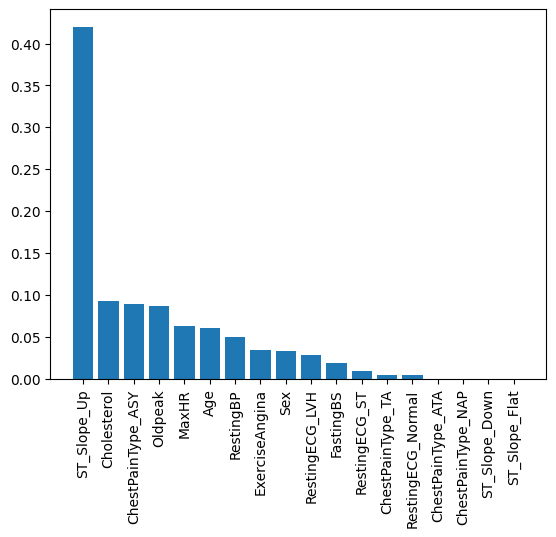

In [11]:
imps = clf.feature_importances_
imps = pd.Series(imps, index=X.columns.tolist())
imps = imps.sort_values(ascending=False)
plt.bar(imps.index,imps.values)
plt.xticks(rotation=90)
plt.show()

It seemes that the most important feature is 'ST_Slope_Up' followed by Cholesterol, existance of ASY type 'ChestPainType', and many others. Having quite many features with low importance may indicate model overfit. 

Let's check the tree:

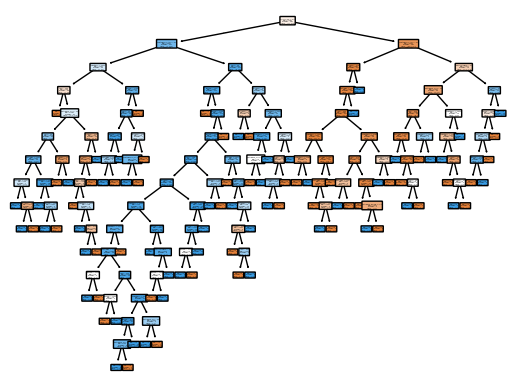

In [12]:
fig = plt.figure()
_ = tree.plot_tree(
    clf,
    feature_names=X.columns.tolist(),
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
)
plt.show()

It looks rather complex, which again may indicate overfit. Let's check the size of the samples at the end nodes, that is at the leaves:

<Axes: xlabel='number of samples at nod'>

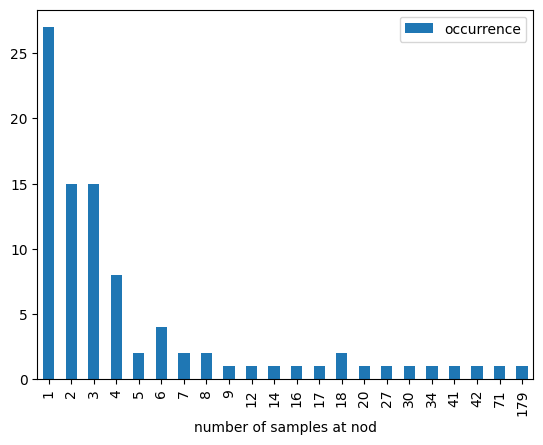

In [13]:
on_leaf = clf.apply(X)

leaves = []
y_np = y.to_numpy()
for i in np.unique(on_leaf):
    leaves.append(y_np[np.argwhere(on_leaf == i)])

sample_count = [len(leaves[count]) for count in range(len(leaves))]
sample_count = pd.DataFrame({"number of samples at nod": sample_count})
sample_count_occur = pd.DataFrame(
    {"occurrence": sample_count.groupby("number of samples at nod").size()}
)
sample_count_occur.plot.bar()

The plot shows that ~27 leaves (around half of the leaves) has sample size of one, and size of two and three also occurs frequently. It tells us, that the model probably overfit and might not be reliable for prediction of a new dataset. We may want to simplifiy the tree to decrease the extent of overfit. 

We saw that a simple decision tree (without setting any parameters) can describe the train dataset perfectly. Let's see how well can this model can predict the test set. 

In [14]:
y_test_pred = clf.predict(X_test)
print(
    f"Accuracy for the test set: {metrics.accuracy_score(y_test, y_test_pred)}"
)

Accuracy for the test set: 0.74


Having 0.74 predictive accuracy is not bad, but we might be able to do better (and we will a bit later). Anyways, we cannot really state, that the simple model has 0.74 for any unseen dataset. That is because we only tried a single unseen dataset and also the model was fitted on a specific train set. So let's see how well simple models trained on various train sets, can predict various test sets:

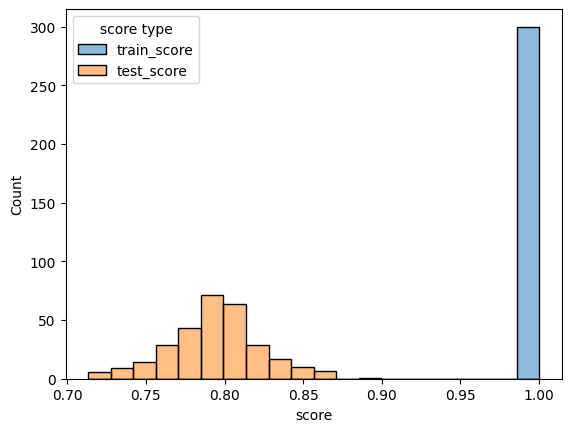

In [15]:
import seaborn as sns

np.random.seed(111)

score_test = []
score_train = []

for _ in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    score_test.append(metrics.accuracy_score(y_test, y_test_pred))
    score_train.append(metrics.accuracy_score(y_train, y_train_pred))

scores = pd.DataFrame(
    {
        "train_score": score_train,
        "test_score": score_test,
    }
)

scores_simple_holdout = pd.melt(
    scores,
    value_vars=["train_score", "test_score"],
    var_name="score type",
    value_name="score",
)
sns.histplot(scores_simple_holdout, x="score", hue="score type", bins=20)

np.random.seed()

It looks we were rather unlucky with our first train-test spplit. Predictive accuracy for random train-test splits varies between around 0.7 and 0.9. The descriptive accuracy is always 100% as we did not limit the tree yet. The sample mean and standard deviation of the predictive accuracy are:

In [16]:
print(f"The mean accuracy: {scores_simple_holdout.loc[scores_simple_holdout["score type"]=="test_score"].score.mean()}"
      + "\n"
      + f"The standard deviation: {scores_simple_holdout.loc[scores_simple_holdout["score type"]=="test_score"].score.std()}")

The mean accuracy: 0.7940444444444444
The standard deviation: 0.029895362336170975


<br/>   <a id='section3'></a>


### <ins>Data evaluation II. : Tuning hyperparameters using the repeated hold-out test set method<ins>

We can simplify the model by pruning it, that is changing the hyperparameters of the model which will results in simpler tree structure. This way, we lose descriptive power, but we gain predictive power. It should be noted that we will choose the best model based on its performance on the test sets. This way we introduce bias in our choice of model, and the predictive accuracy my be over-optimistic. 
<br/>
<br/>
A quick simple example of the phenomenon in which we will check how changing the depth of the tree, changes the accuracy:

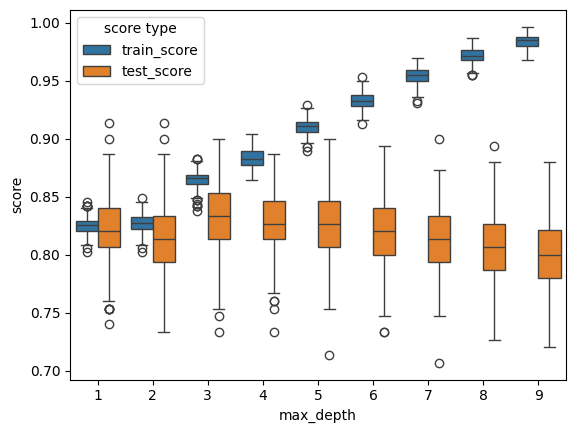

In [17]:
import seaborn as sns

np.random.seed(111)

depths = list(range(1, 10))
scores_train = []
scores_test = []
depths_values = []

for _ in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    for depth in depths:
        clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=111)
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        scores_train.append(metrics.accuracy_score(y_train, y_train_pred))
        y_test_pred = clf.predict(X_test)
        scores_test.append(metrics.accuracy_score(y_test, y_test_pred))
        depths_values.append(depth)

scores = pd.DataFrame(
    {
        "train_score": scores_train,
        "test_score": scores_test,
        "max_depth": depths_values,
    }
)

scores_tuned_holdout_maxdepth = pd.melt(
    scores,
    id_vars=["max_depth"],
    value_vars=["train_score", "test_score"],
    var_name="score type",
    value_name="score",
)

sns.boxplot(
    scores_tuned_holdout_maxdepth, x="max_depth", y="score", hue="score type"
)

np.random.seed()

With increasing depth, that is increasing complexity of the tree, the descriptive power grows, while the predictive power slightly descreases. Considering both descriptive and predictive powers max_depth of 3 may be selected. 



The distribution of accuracy scores at max_depth=3:

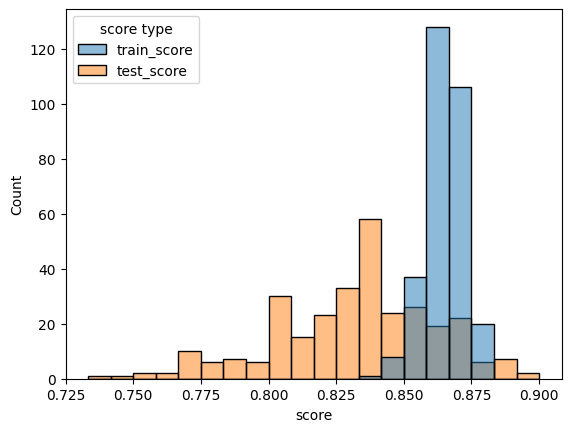

In [19]:
scores_tuned_holdout_depth3 = scores_tuned_holdout_maxdepth.loc[
    scores_tuned_holdout_maxdepth["max_depth"] == 3
]

sns.histplot(scores_tuned_holdout_depth3, x="score", hue="score type", bins=20)


np.random.seed()

The sample mean and standard deviation of the predictive accuracy:


In [20]:
test_scores = scores_tuned_holdout_depth3.loc[
    scores_tuned_holdout_depth3["score type"] == "test_score"
]
train_scores = scores_tuned_holdout_depth3.loc[
    scores_tuned_holdout_depth3["score type"] == "train_score"
]

print(
    f"The mean accuracy for the test sets at max_depth=3: {test_scores.score.mean()}"
    + "\n"
    + f"The standard deviation for the test sets at max_depth=3: {test_scores.score.std()}"
)
print(
    f"The mean accuracy for the train sets at max_depth=3: {train_scores.score.mean()}"
    + "\n"
    + f"The standard deviation for the train sets at max_depth=3: {train_scores.score.std()}"
)

The mean accuracy for the test sets at max_depth=3: 0.8313333333333333
The standard deviation for the test sets at max_depth=3: 0.029586522587836846
The mean accuracy for the train sets at max_depth=3: 0.8648266219239373
The standard deviation for the train sets at max_depth=3: 0.007323107081987941


All in all, it is a decent model. The predictive accuracy increases from 0.79 to 0.83, while the descriptive power decreases from 1 to 0.86 when the hyperparameters of max_depth is tuned. We could also set other hyperparameters so we might be able to increase the accuracy even more. Let's search for the best hyperparameters settings of `max_depth`, `min_samples_leaf`, and `min_samples_split`:

In [21]:
min_samples_splits = [5, 10, 30, 50, 100]
max_depths = [1, 2, 3, 4, 5, 6]
min_samples_leaves = [2, 4, 6, 8, 10, 20, 50]
train_scores = []
test_scores = []
depths = []
leaves = []
splits = []

np.random.seed(111)

for _ in range(60):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    for min_samples_split in min_samples_splits:
        for max_depth in max_depths:
            for min_samples_leaf in min_samples_leaves:
                clf = tree.DecisionTreeClassifier(
                    min_samples_leaf=min_samples_leaf,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=111,
                )
                clf.fit(X_train, y_train)
                y_train_pred = clf.predict(X_train)
                y_test_pred = clf.predict(X_test)
                train_scores.append(
                    metrics.accuracy_score(y_train, y_train_pred)
                )
                test_scores.append(metrics.accuracy_score(y_test, y_test_pred))
                depths.append(max_depth)
                leaves.append(min_samples_leaf)
                splits.append(min_samples_split)

scores_tuned_holdout_hyps = pd.DataFrame(
    {
        "train_score": train_scores,
        "test_score": test_scores,
        "depth": depths,
        "leaf": leaves,
        "split": splits,
    }
)
scores_tuned_holdout_hyps_mean = scores_tuned_holdout_hyps.groupby(
    ["depth", "leaf", "split"]
).mean()

np.random.seed()

The best (mean) results by the values of max_depth:

In [22]:
for depth in set(depths):
    depth_scores = scores_tuned_holdout_hyps_mean[
        scores_tuned_holdout_hyps_mean.index.get_level_values(0) == depth
    ]
    depth_scores_bests = depth_scores.loc[
        depth_scores["test_score"] == max(depth_scores["test_score"])
    ]
    display(depth_scores_bests.iloc[0, :])

train_score    0.825643
test_score     0.819444
Name: (1, 2, 5), dtype: float64

train_score    0.827685
test_score     0.813556
Name: (2, 50, 5), dtype: float64

train_score    0.859871
test_score     0.834222
Name: (3, 20, 50), dtype: float64

train_score    0.863842
test_score     0.836222
Name: (4, 20, 5), dtype: float64

train_score    0.878971
test_score     0.836778
Name: (5, 6, 30), dtype: float64

train_score    0.878831
test_score     0.837556
Name: (6, 10, 30), dtype: float64

The different hyperparameter sets result similar models. Considering simplicity and the accuracy scores, here the max_depth=3 parameter set is selected as final one. Let's check the distribution of the accuracy for the model with these hyperparameters:

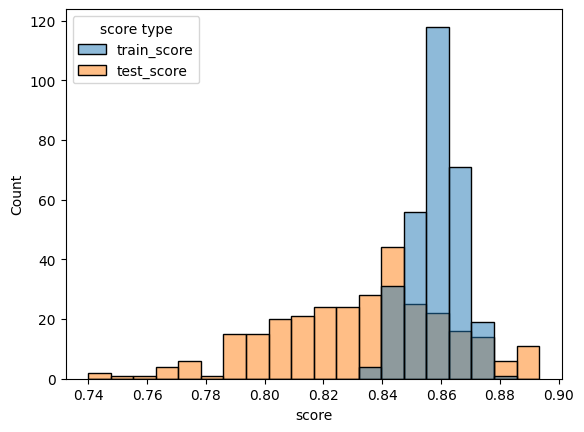

In [23]:
np.random.seed(111)

score_test = []
score_train = []

for _ in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = tree.DecisionTreeClassifier(
        max_depth=3, min_samples_leaf=20, min_samples_split=50
    )
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    score_test.append(metrics.accuracy_score(y_test, y_test_pred))
    score_train.append(metrics.accuracy_score(y_train, y_train_pred))

scores = pd.DataFrame(
    {
        "train_score": score_train,
        "test_score": score_test,
    }
)
scores_tuned_holdout_hyps_best = pd.melt(
    scores,
    value_vars=["train_score", "test_score"],
    var_name="score type",
    value_name="score",
)
sns.histplot(
    scores_tuned_holdout_hyps_best, x="score", hue="score type", bins=20
)

np.random.seed()

The estimates of the expected value and the variance are:

In [24]:
test_scores = scores_tuned_holdout_hyps_best.loc[
    scores_tuned_holdout_hyps_best["score type"] == "test_score"
]
train_scores = scores_tuned_holdout_hyps_best.loc[
    scores_tuned_holdout_hyps_best["score type"] == "train_score"
]

print(
    f"The mean accuracy for the test sets: {test_scores.score.mean()}"
    + "\n"
    + f"The standard deviation for the test sets: {test_scores.score.std()}"
)
print(
    f"The mean accuracy for the train sets: {train_scores.score.mean()}"
    + "\n"
    + f"The standard deviation for the train sets: {train_scores.score.std()}"
)

The mean accuracy for the test sets: 0.8331111111111111
The standard deviation for the test sets: 0.029477467581324752
The mean accuracy for the train sets: 0.8586633109619686
The standard deviation for the train sets: 0.00825530903527311


We could not increase the accuracy further compared to the previous solution where only max_depth=3 was set as hyperparameter. Our results using a single hold-out set (repeated times) is that we should use only the hyperparameter of depth and set it to 3. This model results in mean predictive accuracy of 0.83 with 0.029 standard deviation. However, it should be noted that we chose the best model based on its performance on the test sets. This way we introduce bias in our choice of model, and the predictive accuracy my be over-optimistic. The important features are and the tree:

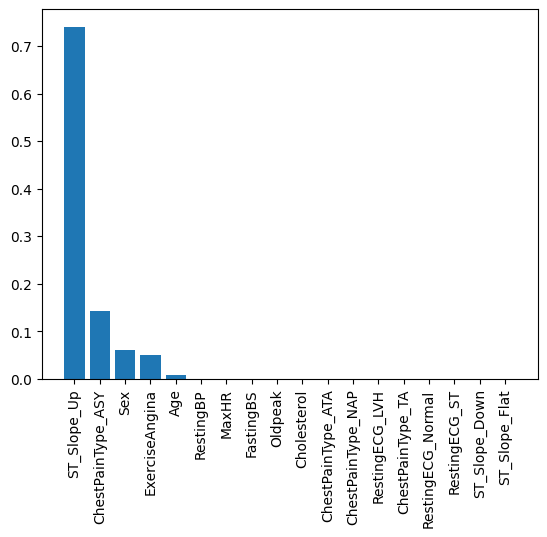

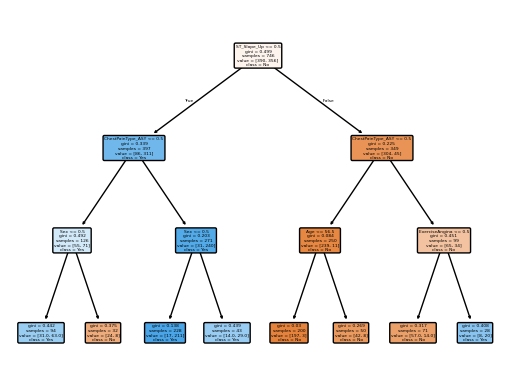

In [25]:
clf.fit(X, y)

imps = clf.feature_importances_
imps = pd.Series(imps, index=X.columns.tolist())
imps = imps.sort_values(ascending=False)
plt.bar(imps.index, imps.values)
plt.xticks(rotation=90)


fig = plt.figure()
_ = tree.plot_tree(
    clf,
    feature_names=X.columns.tolist(),
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
)

plt.show()

<br/>   <a id='section4'></a>

### <ins>Data evaluation III. : Tuning hyperparameters using k-fold cross-validation<ins>

<br/> Here, we will use cross-validation to tune the hyperparameters. The whole set is partitioned into folds. Then, we leave out each fold one-by-one (those will be the test sets) while fitting on the others, and check the accuracy for the left out one. This way we can check the predictive power of the model for different test sets. In the meantime, we will search for the "best" parameter settings of the tree with which best predictive power can be achieved.

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# defining the candidate levels of the parameters
param_grid = {
    "min_samples_split": [5, 10, 30, 50, 100],
    "max_depth": [1, 2, 3, 4, 5, 6],
    "min_samples_leaf": [2, 4, 6, 8, 10, 20, 50],
}

clf = tree.DecisionTreeClassifier(random_state=111)
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1
)
grid_search.fit(X, y)

final_model = grid_search.best_estimator_
display(grid_search.best_estimator_)

clf = final_model

clf.fit(X, y)
y_pred = clf.predict(X)

print(f"Accuracy for the train set: {metrics.accuracy_score(y, y_pred)}")

c:\Users\Mihalovits\Projects\Machine Learning\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, min_samples_split=5,
                       random_state=111)

Accuracy for the train set: 0.824396782841823


We obtained the best model (with tuned hyperparameters) based on a single (random) train-test split in the cross-validation. Let's see how well the model predict new test sets:

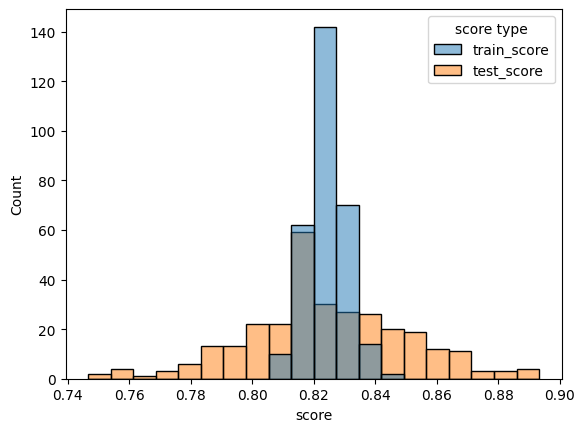

In [27]:
np.random.seed(111)

score_test = []
score_train = []

for _ in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = tree.DecisionTreeClassifier(
        max_depth=1, min_samples_leaf=2, min_samples_split=5
    )
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    score_test.append(metrics.accuracy_score(y_test, y_test_pred))
    score_train.append(metrics.accuracy_score(y_train, y_train_pred))

scores = pd.DataFrame(
    {
        "train_score": score_train,
        "test_score": score_test,
    }
)

scores_single_cv_best = pd.melt(
    scores,
    value_vars=["train_score", "test_score"],
    var_name="score type",
    value_name="score",
)
sns.histplot(scores_single_cv_best, x="score", hue="score type", bins=20)

np.random.seed()

We obtained similar, but slightly less predictive accuracy then with the repeated hold-out test set method. The important features and the tree:

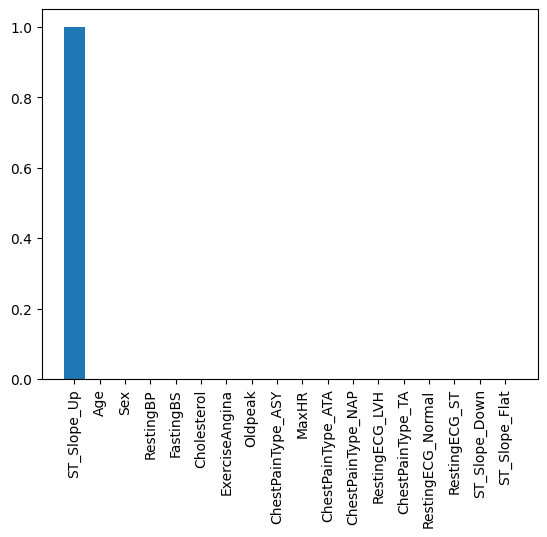

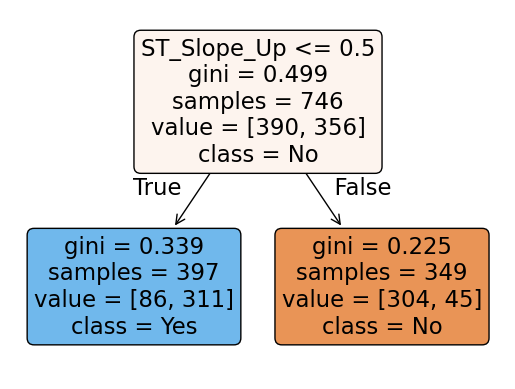

In [28]:
clf.fit(X, y)

imps = clf.feature_importances_
imps = pd.Series(imps, index=X.columns.tolist())
imps = imps.sort_values(ascending=False)
plt.bar(imps.index, imps.values)
plt.xticks(rotation=90)

fig = plt.figure()
_ = tree.plot_tree(
    clf,
    feature_names=X.columns.tolist(),
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
)

plt.show()

As it turns out, using a single feautre is enough to reach 0.82 predictive accuracy on average. However, we based our model building on a single train-test split in the cross-validation process. It would be advantegous to see how well the built model(s) perform when different train-test splits are used.  


<br/>   <a id='section5'></a>

### <ins>Data evaluation IV. : Tuning hyperparameters using repeated k-fold cross-validation<ins>

<br/>   <a id='section6'></a>

### <ins>Data evaluation V. : Tuning hyperparameters using nested cross-validation<ins>

In nested cross-validation we can check the performance of our models that we obtained through our model building method. The *best* models are obtained through repeated train-test splitting, using cross-validation on the train set (inner cv) to tune the hyperparameters and on the test set (outer cv) as well to obtain the predictive accuracy for multiple test sets using the tuned models. As different hyperparameters might obtained based on the train-test split, the inner cv might construct different models. It is not a problem, as our aim, is to see the performance of the whole process, not to see the performance of a specific tuned model. If we are satisfied with the distribution of the predictive accuracy of the whole process, we can use simple cv to obtain the final model. Generally, we would compare the predictive accuracies obtained from various tpye of machine learning models, and chose the type of model with the best results. Here, we only considering decisiontree as our macine learning model. 

